In [ ]:
from google.colab import drive
import zipfile

# Mount Google Drive
drive.mount('/content/drive')

# Path to your zip file in Google Drive
zip_file_path = '/content/drive/My Drive/braintumor_data.zip'  # Replace with the actual path

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all contents to a specific directory
        zip_ref.extractall('/content/extracted_files')  # Creates 'extracted_files' directory

        print(f"Successfully extracted '{zip_file_path}' to '/content/extracted_files'")
except FileNotFoundError:
    print(f"Error: Zip file not found at '{zip_file_path}'")
except zipfile.BadZipFile:
    print(f"Error: Invalid zip file at '{zip_file_path}'")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


In [ ]:
import os

image_dir = "/content/extracted_files/images"
mask_dir = "/content/extracted_files/masks"

print("Number of images:", len(os.listdir(image_dir)))
print("Number of masks:", len(os.listdir(mask_dir)))


Number of images: 3064
Number of masks: 3064


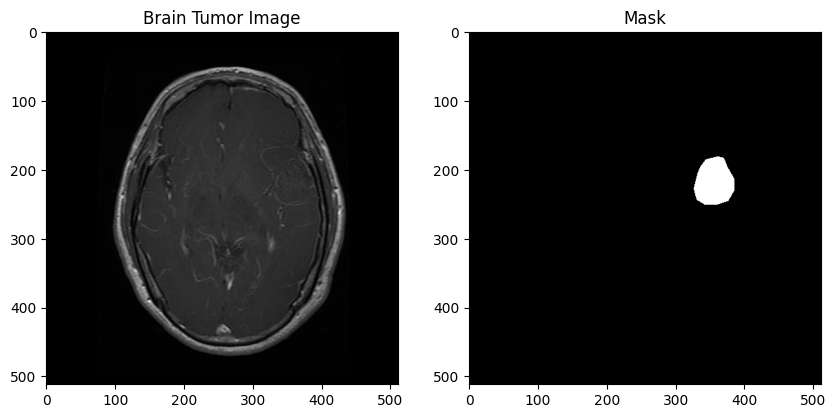

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load an example image and mask
image_path = os.path.join(image_dir, os.listdir(image_dir)[0])
mask_path = os.path.join(mask_dir, os.listdir(mask_dir)[0])

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct visualization
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask in grayscale

# Plot image and mask
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title("Brain Tumor Image")
ax[1].imshow(mask, cmap="gray")
ax[1].set_title("Mask")
plt.show()


Resize, Normalize & Convert Masks to Binary

In [ ]:
#!pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, Activation
from tensorflow.keras.layers import MaxPooling2D, Concatenate, Dropout
from tensorflow.keras.layers import ConvLSTM2D, Reshape
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from tensorflow.data import Dataset
import os

IMG_SIZE = 256  # Resize to 256x256

def preprocess_image(image_path, mask_path):
    # Load image and mask
    image = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    mask = load_img(mask_path, target_size=(IMG_SIZE, IMG_SIZE), color_mode="grayscale")

    # Convert to arrays
    image = img_to_array(image) / 255.0  # Normalize image
    mask = img_to_array(mask) / 255.0  # Normalize mask
    mask = np.where(mask > 0.5, 1, 0)  # Convert to binary (0s & 1s)

    return image, mask

# Data Augmentation Using TensorFlow
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

def augment(image, mask):
    combined = tf.concat([image, mask], axis=-1)  # Combine image and mask for consistent transformation
    augmented = data_augmentation(combined)

    image = augmented[:, :, :3]  # Extract augmented image
    mask = augmented[:, :, 3:]  # Extract augmented mask

    # Set the shape explicitly to avoid unknown TensorShape
    image.set_shape([IMG_SIZE, IMG_SIZE, 3])
    mask.set_shape([IMG_SIZE, IMG_SIZE, 1])
    return image, mask

# Get list of image and mask file paths
image_paths = sorted([os.path.join(image_dir, img) for img in os.listdir(image_dir)])
mask_paths = sorted([os.path.join(mask_dir, mask) for mask in os.listdir(mask_dir)])

# Define TensorFlow Dataset
def load_dataset(image_paths, mask_paths):
   def load_data(image_path, mask_path):
        image_path = image_path.numpy().decode('utf-8')
        mask_path = mask_path.numpy().decode('utf-8')
        image, mask = preprocess_image(image_path, mask_path)
        image = tf.convert_to_tensor(image, dtype=tf.float32)
        mask = tf.convert_to_tensor(mask, dtype=tf.float32)

        return image, mask

   def load_data_tf(image_path, mask_path):
        image, mask = tf.py_function(func=load_data, inp=[image_path, mask_path], Tout=[tf.float32, tf.float32])

        # Explicitly set shapes outside tf.py_function()
        image.set_shape([IMG_SIZE, IMG_SIZE, 3])
        mask.set_shape([IMG_SIZE, IMG_SIZE, 1])




        return image, mask

   dataset = Dataset.from_tensor_slices((image_paths, mask_paths))
   dataset = dataset.map(load_data_tf, num_parallel_calls=tf.data.AUTOTUNE)
   dataset = dataset.map(augment,num_parallel_calls=tf.data.AUTOTUNE)
   dataset = dataset.batch(8).shuffle(100).prefetch(tf.data.AUTOTUNE)
   return dataset

train_dataset = load_dataset(image_paths, mask_paths)

Build the U-Net + LSTM Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, Activation
from tensorflow.keras.layers import MaxPooling2D, Concatenate, Dropout
from tensorflow.keras.layers import ConvLSTM2D, Reshape
from tensorflow.keras.models import Model
import re
from tensorflow.keras.layers import Flatten, Dense, Bidirectional, LSTM


IMG_SIZE = 256
FILTERS = 64

def conv_block(inputs, num_filters, block_name):  # Add block_name argument
    """Convolutional block: Conv -> BN -> ReLU -> Conv -> BN -> ReLU"""

    block_name = re.sub(r"[^A-Za-z0-9_.\\/>-]", "_", block_name)
    print(f"Block name: {block_name}")

    x = Conv2D(num_filters, (3, 3), padding="same", name=f"{block_name}_conv1")(inputs)
    x = BatchNormalization(trainable=False, name=f"{block_name}_bn1")(x)
    x = Activation("relu", name=f"{block_name}_relu1")(x)

    x = Conv2D(num_filters, (3, 3), padding="same",name=f"{block_name}_conv2")(x)
    x = BatchNormalization(trainable=False,name=f"{block_name}_bn2")(x)
    x = Activation("relu" , name=f"{block_name}_relu2")(x)

    return x

def encoder_block(inputs, num_filters,block_num):
    """Encoder: Conv Block -> MaxPool"""
    x = conv_block(inputs, num_filters, f"encoder_{block_num}_conv_block")  # Pass block name
    p = MaxPooling2D((2, 2),name=f"encoder_block_{block_num}_maxpool")(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters,block_num):
    """Decoder: UpSample -> Concatenate -> Conv Block"""
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same", name=f"decoder_block_{block_num}_convtranspose")(inputs)
    x = Concatenate(name=f"decoder_block{block_num}_concat")([x, skip_features])
    x = conv_block(x, num_filters, f"decoder_{block_num}_conv_block")  # Pass block name
    return x

def build_unet_lstm():
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))  # Input shape (256, 256, 3)

    # Encoder
    s1, p1 = encoder_block(inputs, FILTERS,1)
    s2, p2 = encoder_block(p1, FILTERS * 2,2)
    s3, p3 = encoder_block(p2, FILTERS * 4,3)
    s4, p4 = encoder_block(p3, FILTERS * 8,4)

    # Bottleneck with ConvLSTM2D
    '''x = Reshape((1, IMG_SIZE // 16, IMG_SIZE // 16, FILTERS * 8), name="bottleneck_reshape1")(p4)  # Reshape for ConvLSTM2D
    x = ConvLSTM2D(FILTERS * 8, (3, 3), padding="same", return_sequences=False, name="bottleneck_convlstm")(x)  # LSTM Layer
    x = Reshape((IMG_SIZE // 16, IMG_SIZE // 16, FILTERS * 8), name="bottleneck_reshape2")(x)  # Reshape back'''
    x=Flatten()(p4)
    x = Reshape((-1, FILTERS * 8))(x)
    x = Bidirectional(LSTM(256, return_sequences=False),name="bottleneck_bilstm")(x)
    x = Dense((IMG_SIZE // 16) * (IMG_SIZE // 16) * (FILTERS * 8), activation="relu")(x)
    x = Reshape((IMG_SIZE // 16, IMG_SIZE // 16, FILTERS * 8), name="bottleneck_reshape")(x)

    # Decoder
    x = decoder_block(x, s4, FILTERS * 8,1)
    x = decoder_block(x, s3, FILTERS * 4,2)
    x = decoder_block(x, s2, FILTERS * 2,3)
    x = decoder_block(x, s1, FILTERS,4)

    # Output Layer
    outputs = Conv2D(1, (1, 1), activation="sigmoid", name="output_layer")(x)

    # Model
    model = Model(inputs, outputs, name="UNetLSTM")
    return model

In [ ]:
# Build and compile the model
model = build_unet_lstm()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Define Callbacks for Training

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

checkpoint = ModelCheckpoint("unet_lstm_best.h5", monitor="val_loss", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1, restore_best_weights=True)

callbacks = [checkpoint, reduce_lr, early_stopping]


Train the Model

In [ ]:
EPOCHS = 10
BATCH_SIZE = 8

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=train_dataset,  # You can create a separate validation set if needed
)


Epoch 1/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.9566 - loss: 0.1857
Epoch 1: val_loss improved from inf to 0.06859, saving model to unet_lstm_best.h5


383/383 ━━━━━━━━━━━━━━━━━━━━ 394s 937ms/step - accuracy: 0.9566 - loss: 0.1855 - val_accuracy: 0.9799 - val_loss: 0.0686 - learning_rate: 1.0000e-04
Epoch 2/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.9826 - loss: 0.0603
Epoch 2: val_loss improved from 0.06859 to 0.06815, saving model to unet_lstm_best.h5


383/383 ━━━━━━━━━━━━━━━━━━━━ 370s 929ms/step - accuracy: 0.9826 - loss: 0.0603 - val_accuracy: 0.9799 - val_loss: 0.0682 - learning_rate: 1.0000e-04
Epoch 3/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.9826 - loss: 0.0589
Epoch 3: val_loss improved from 0.06815 to 0.06495, saving model to unet_lstm_best.h5


383/383 ━━━━━━━━━━━━━━━━━━━━ 393s 985ms/step - accuracy: 0.9826 - loss: 0.0589 - val_accuracy: 0.9798 - val_loss: 0.0649 - learning_rate: 1.0000e-04
Epoch 4/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.9823 - loss: 0.0571
Epoch 4: val_loss did not improve from 0.06495
383/383 ━━━━━━━━━━━━━━━━━━━━ 357s 893ms/step - accuracy: 0.9823 - loss: 0.0571 - val_accuracy: 0.9797 - val_loss: 0.0690 - learning_rate: 1.0000e-04
Epoch 5/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.9830 - loss: 0.0531
Epoch 5: val_loss improved from 0.06495 to 0.05931, saving model to unet_lstm_best.h5


383/383 ━━━━━━━━━━━━━━━━━━━━ 373s 937ms/step - accuracy: 0.9830 - loss: 0.0531 - val_accuracy: 0.9797 - val_loss: 0.0593 - learning_rate: 1.0000e-04
Epoch 6/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.9835 - loss: 0.0485
Epoch 6: val_loss improved from 0.05931 to 0.05844, saving model to unet_lstm_best.h5


383/383 ━━━━━━━━━━━━━━━━━━━━ 372s 931ms/step - accuracy: 0.9835 - loss: 0.0485 - val_accuracy: 0.9805 - val_loss: 0.0584 - learning_rate: 1.0000e-04
Epoch 7/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.9845 - loss: 0.0438
Epoch 7: val_loss improved from 0.05844 to 0.04917, saving model to unet_lstm_best.h5


383/383 ━━━━━━━━━━━━━━━━━━━━ 372s 932ms/step - accuracy: 0.9844 - loss: 0.0438 - val_accuracy: 0.9822 - val_loss: 0.0492 - learning_rate: 1.0000e-04
Epoch 8/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.9844 - loss: 0.0423
Epoch 8: val_loss improved from 0.04917 to 0.04604, saving model to unet_lstm_best.h5


383/383 ━━━━━━━━━━━━━━━━━━━━ 407s 1s/step - accuracy: 0.9844 - loss: 0.0423 - val_accuracy: 0.9826 - val_loss: 0.0460 - learning_rate: 1.0000e-04
Epoch 9/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.9853 - loss: 0.0372
Epoch 9: val_loss improved from 0.04604 to 0.04183, saving model to unet_lstm_best.h5


383/383 ━━━━━━━━━━━━━━━━━━━━ 444s 1s/step - accuracy: 0.9853 - loss: 0.0372 - val_accuracy: 0.9831 - val_loss: 0.0418 - learning_rate: 1.0000e-04
Epoch 10/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 586ms/step - accuracy: 0.9858 - loss: 0.0360
Epoch 10: val_loss improved from 0.04183 to 0.03770, saving model to unet_lstm_best.h5


383/383 ━━━━━━━━━━━━━━━━━━━━ 388s 977ms/step - accuracy: 0.9858 - loss: 0.0360 - val_accuracy: 0.9845 - val_loss: 0.0377 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 10.


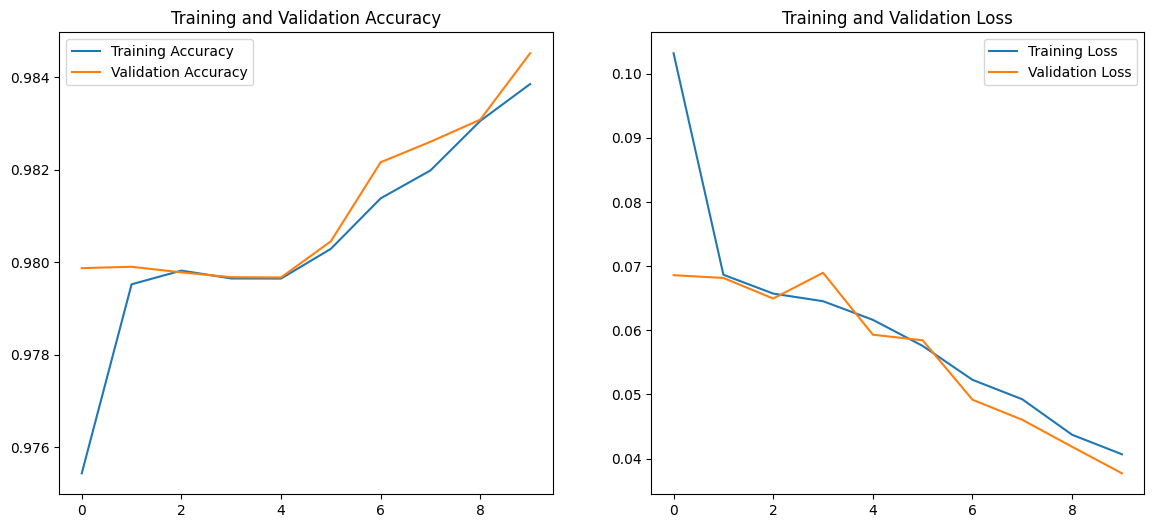

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Training Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Training Loss")
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    plt.show()

plot_metrics(history)


In [ ]:
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model("unet_lstm_best.h5", compile=False)

# Compile the model before evaluating
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), # Re-compile with the same settings used during training
              loss="binary_crossentropy",
              metrics=["accuracy"])

# Evaluate on validation data
val_loss, val_accuracy = best_model.evaluate(train_dataset)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

383/383 ━━━━━━━━━━━━━━━━━━━━ 122s 274ms/step - accuracy: 0.9860 - loss: 0.0345
Validation Accuracy: 0.9844
Validation Loss: 0.0380


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


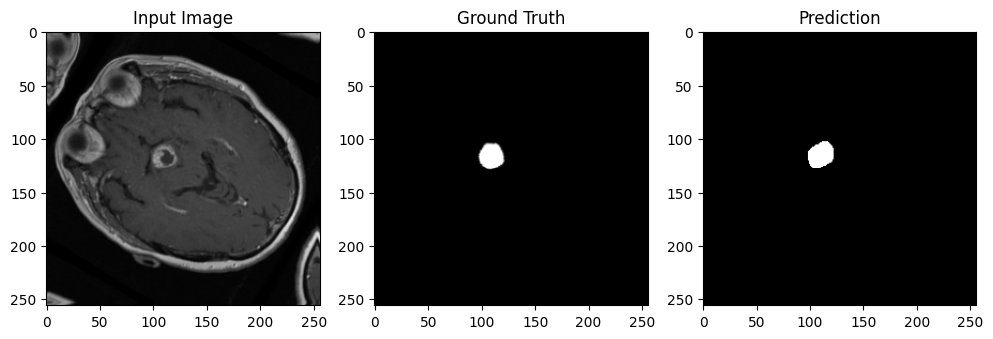

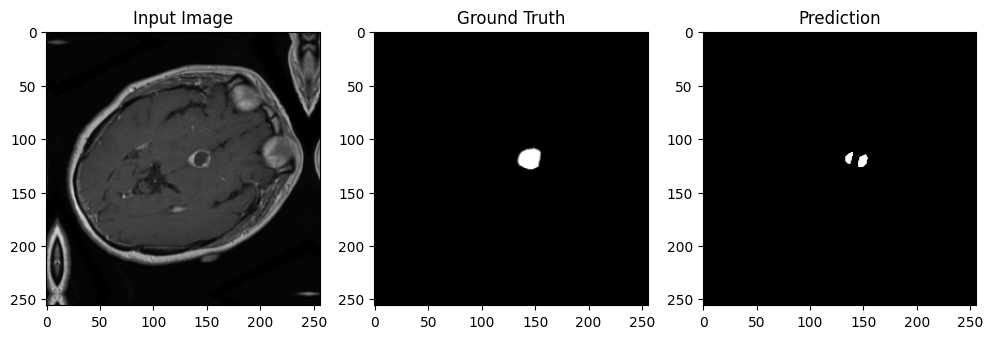

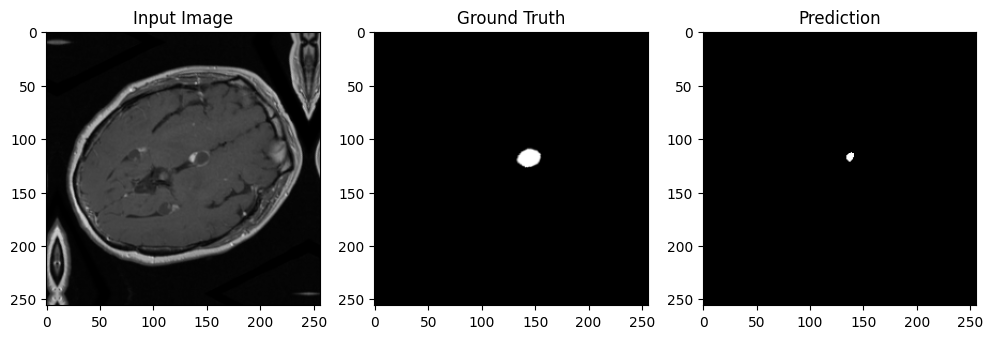

In [ ]:
import numpy as np

def display_sample_predictions(model, dataset, num_samples=3):
    for images, masks in dataset.take(1):
        preds = model.predict(images[:num_samples])
        preds = (preds > 0.5).astype(np.uint8)

        for i in range(num_samples):
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.imshow(images[i])
            plt.title("Input Image")

            plt.subplot(1, 3, 2)
            plt.imshow(tf.squeeze(masks[i]), cmap='gray')
            plt.title("Ground Truth")

            plt.subplot(1, 3, 3)
            plt.imshow(tf.squeeze(preds[i]), cmap='gray')
            plt.title("Prediction")

            plt.show()

display_sample_predictions(best_model, train_dataset)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


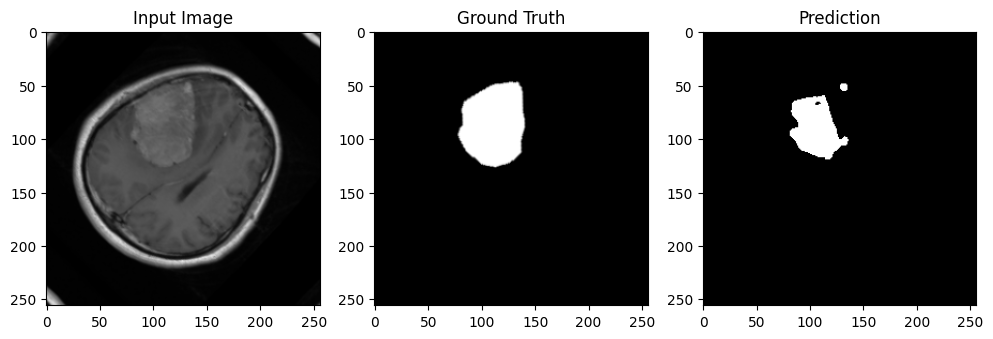

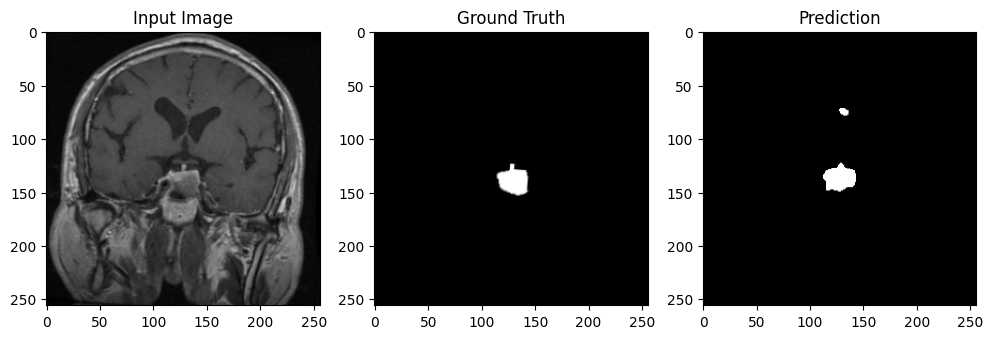

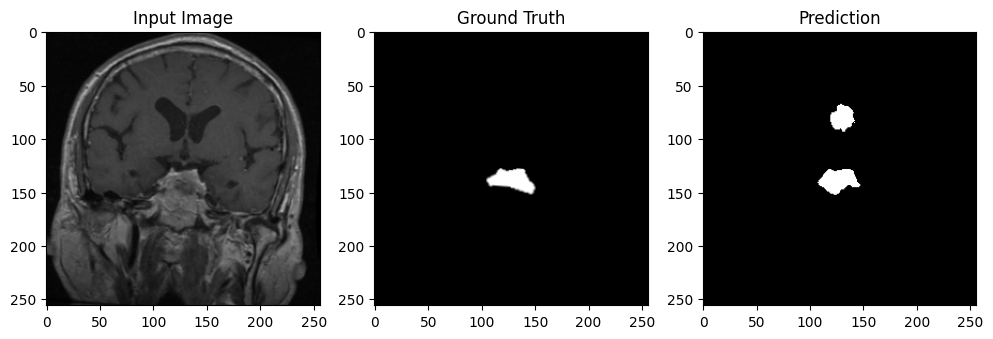

Evaluation Metrics:
Precision: 0.7745415318230853
Recall: 0.6455383232187009
Dice/F1 Score: 0.7041804585019003


In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow as tf
import matplotlib.pyplot as plt

def display_sample_predictions(model, dataset, num_samples=3):
    for images, masks in dataset.take(1):
        preds = model.predict(images[:num_samples])
        preds = (preds > 0.5).astype(np.uint8)

        for i in range(num_samples):
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.imshow(images[i])
            plt.title("Input Image")

            plt.subplot(1, 3, 2)
            plt.imshow(tf.squeeze(masks[i]), cmap='gray')
            plt.title("Ground Truth")

            plt.subplot(1, 3, 3)
            plt.imshow(tf.squeeze(preds[i]), cmap='gray')
            plt.title("Prediction")

            plt.show()

        # Flatten all masks and predictions for metric calculation
        y_true = masks[:num_samples].numpy().astype(np.uint8).flatten()
        y_pred = preds.flatten()

        print("Evaluation Metrics:")
        print("Precision:", precision_score(y_true, y_pred))
        print("Recall:", recall_score(y_true, y_pred))
        print("Dice/F1 Score:", f1_score(y_true, y_pred))

# Call the function
display_sample_predictions(best_model, train_dataset)


In [ ]:
# ... (your previous code) ...

# Assuming you want a 20/80 train/test split
from sklearn.model_selection import train_test_split

image_paths = sorted([os.path.join(image_dir, img) for img in os.listdir(image_dir)])
mask_paths = sorted([os.path.join(mask_dir, mask) for mask in os.listdir(mask_dir)])

train_image_paths, test_image_paths, train_mask_paths, test_mask_paths = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)

train_dataset = load_dataset(train_image_paths, train_mask_paths)
test_dataset = load_dataset(test_image_paths, test_mask_paths) # Create the test dataset

# ... (rest of your code) ...

test_loss, test_accuracy = best_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")

77/77 ━━━━━━━━━━━━━━━━━━━━ 29s 214ms/step - accuracy: 0.9852 - loss: 0.0363
Test Accuracy: 0.9845


In [ ]:
test_loss, test_accuracy = best_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")


77/77 ━━━━━━━━━━━━━━━━━━━━ 26s 181ms/step - accuracy: 0.9851 - loss: 0.0372
Test Accuracy: 0.9851


In [ ]:
best_model.save("final_unet_lstm_model.keras")
